In [42]:
# SETUP DEPENDENCIES

from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain_openai import ChatOpenAI, OpenAI

import openai
from os import getenv, environ

if "OPENAI_API_KEY" not in environ:
    raise EnvironmentError("Please provide an OpenAI API Key in the environment variable in 'OPENAI_API_KEY'.")
openai.key = getenv("OPENAI_API_KEY")

from pathlib import Path
import pandas as pd

DATASET = Path().resolve() / "LLM_Data.csv"

TESTBANK = Path().resolve() / "testbank"
GIVEN_TESTS = TESTBANK / "given.csv"
CUSTOM_TESTS = TESTBANK / "custom.csv"

OUTPUT = Path().resolve() / "output"

assert DATASET.exists(), f"Dataset not found at {DATASET}"
assert GIVEN_TESTS.exists(), f"Given tests file not found at {GIVEN_TESTS}"
assert CUSTOM_TESTS.exists(), f"Custom tests file not found at {CUSTOM_TESTS}"

if not OUTPUT.exists():
    OUTPUT.mkdir()
assert OUTPUT.exists(), f"Output directory not found at {OUTPUT}"

In [30]:
# SETUP AGENT

agent = create_csv_agent(
    OpenAI(temperature=0), # can specify model and temperature
    str(DATASET),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, # can be changed to few shot 
)

In [31]:
# SETUP PROMPT TEMPLATE

def prompt_template(query):
        return f"""
Given a dataset that tracks repair patterns, part failure trends, and repair frequencies across different car models and years, analyze the following fields to answer the query:

- PartID: Unique identifier for each part. This is crucial for tracking specific parts across multiple repairs.
- RepairID: Unique identifier for each repair instance, which is associated with a specific CarID. This helps in identifying and analyzing repair instances for individual cars.
- CarID: Unique identifier for cars. A single CarID may have multiple RepairIDs, indicating that a car has undergone multiple repairs.
- DemandDate: The date when the repair was demanded. It is important to note the date format for consistency in analysis.
- Quantity: The number of parts used or required for the repair. This field is key for understanding the demand for different parts.
- ModelYear: The year the car model was manufactured. This information is vital for analyzing trends across different model years.

Based on the above dataset structure, please evaluate the following query: 
{query}
"""




> Entering new AgentExecutor chain...
Thought: We need to filter the dataframe to only include data from 2023 and then group by ModelYear and sum the Quantity column to find the highest value.
Action: python_repl_ast
Action Input: df[df['DemandDate'].str.contains('2023')].groupby('ModelYear')['Quantity'].sum()AttributeError: Can only use .str accessor with string values! We need to convert the DemandDate column to a datetime format before filtering.
Action: python_repl_ast
Action Input: df['DemandDate'] = pd.to_datetime(df['DemandDate'])

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 Now we can filter the dataframe and group by ModelYear to find the highest quantity consumed.
Action: python_repl_ast
Action Input: df[df['DemandDate'].dt.year == 2023].groupby('ModelYear')['Quantity'].sum()ModelYear
2012.0      558
2013.0     3774
2014.0     5809
2015.0    10213
2016.0     9093
2017.0     2271
2018.0     1355
2019.0      510
2020.0      492
2021.0      350
2022.0      343
2023.0      189
Name: Quantity, dtype: int64 The highest quantity consumed in 2023 is for the 2015 model year.
Final Answer: 2015

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to count the number of unique CarIDs that have more than one RepairID associated with them.
Action: python_repl_ast
Action Input: df.groupby('CarID')['RepairID'].nunique()CarID
0001bbb70a10a671387a048d9d96856f    1
000336723f84462bec2b53cfeeccf31b    1
00038930268d468dafa8555a025dbfb0    1
000749e8222f257e9652a85209a27eb9    1
00097f5af4b7802c80f2450d9a305df1    1
                                  

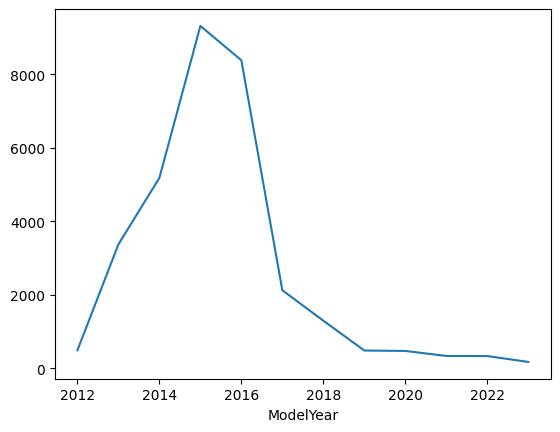

In [45]:
# TESTING AND EVALUATION

tests_dataframe = pd.read_csv(GIVEN_TESTS)

responses = []

for idx, row in tests_dataframe.iterrows():
    query = row["query"]
    response = agent.run(prompt_template(query))
    responses.append(response)
    
tests_dataframe["response"] = responses
tests_dataframe.to_csv(OUTPUT / "given_responses.csv", index=False)